
this notebook contains all plot used in our report.

In [1]:
import numpy as np
import torch
import scipy
import os
import matplotlib.pyplot as plt

## 1. MNIST experiments

## Imports

In [2]:
from ManifoldProjectLoss import ManifoldProjection
import torchvision
import torchvision.transforms as transforms
from sklearn.neighbors import NearestNeighbors



## Load MNIST data

In [3]:


# Download MNIST training
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

#  Convert training data to NumPy arrays
train_images = trainset.data.numpy()   # Shape: (60000, 28, 28)
train_labels = trainset.targets.numpy()  # Shape: (60000,)
test_images = testset.data.numpy()    # Shape: (10000, 28, 28)
test_labels = testset.targets.numpy()  # Shape: (10000,)

# flatten images into normalized vectors
X_train = train_images.reshape(train_images.shape[0], -1)  / 255 # Shape: (60000, 784)
X_test = test_images.reshape(test_images.shape[0], -1)  /255   # Shape: (10000, 784)
Y_train = train_labels
Y_test = test_labels
# shapes print
print(f"Train images shape: {X_train.shape}, Train labels shape: {Y_train.shape}")
print(f"Test images shape: {X_test.shape}, Test labels shape: {Y_test.shape}")

def get_image(flatten_img):
    return flatten_img.reshape(28, 28)

index_4_test = np.where(test_labels==4)[0]
index_8_test = np.where(test_labels==8)[0]
index_9_test = np.where(test_labels==9)[0]


Train images shape: (60000, 784), Train labels shape: (60000,)
Test images shape: (10000, 784), Test labels shape: (10000,)


In [4]:
    
def gradient_descent_on_manifold_cost_function(start, end, data):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr=1e-2
    img_x = start
    img_y = end
    x = torch.tensor(img_x).to(device).requires_grad_(True)# 7
    y = torch.tensor(img_y).to(device) # 0
    
    manifold_proj = ManifoldProjection(torch.tensor(data), k_neighbor=15, closing_manifold_ratio=0.1, manifold_ratio=0.8, device=device)
    optimizer = torch.optim.SGD([x], lr=lr)
    num_iterations = 104
    history = []
    # Gradient descent loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        loss = manifold_proj(x,y)
        loss.backward()
        optimizer.step()
        
        history.append(x.clone().detach().to("cpu").numpy())
    history = np.array(history)
    return history

In [5]:
def save_plots(history, name, labels = None):
    os.makedirs('./plots',exist_ok=True )
    os.makedirs(f'./plots/{name}', exist_ok=True )
    if labels is None:
        labels = range(len(history))
    iterator = zip(history, labels)
    for flatten_img,label in iterator:
        img = flatten_img.reshape(28,28)
        plt.imsave(f"./plots/{name}/mnist_{name}_{label}.png", img)
def check_plots(history):
    fig, axes = plt.subplots(len(history) // 4, 2, figsize=(50, 400))
    axes = axes.flatten()
    for k,ax in enumerate(axes):
        img = history[2*k].reshape(28,28)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{2*k}th iteration")

### Experiment transformation 7 to 0

In [6]:
history = gradient_descent_on_manifold_cost_function(X_test[0], X_test[3], X_train)

# Generate plots in the img/7_to_0 folder.
save_plots(history[::10], "7_to_0", labels= [10*k for k in range(len(history)//10)])


## Experiment transformation 8 to 9

In [7]:
img_x = X_test[index_8_test[1]]
img_y = X_test[index_9_test[0]]
history = gradient_descent_on_manifold_cost_function(img_x, img_y, X_train)
# Generate plots in the img/8_to_9 folder.
save_plots(history[::10], "8_to_9", labels= [10*k for k in range(len(history)//10)])

# 2. Sinkhorn experiments

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from random import choices
from imageio import imread
from geomloss import SamplesLoss


[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc: No such file or directory
collect2: error: ld returned 1 exit status

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc: No such file or directory
collect2: error: ld returned 1 exit status

OK


In [9]:

def load_image(fname):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1, :]) / 255.0
    return 1 - img


def draw_samples(fname, n, dtype=torch.FloatTensor):
    A = load_image(fname)
    xg, yg = np.meshgrid(
        np.linspace(0, 1, A.shape[0]),
        np.linspace(0, 1, A.shape[1]),
        indexing="xy",
    )

    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return torch.from_numpy(dots).type(dtype)


def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")

def display_samples3D(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], x_[:, 2], s=20, c=color, edgecolors="none")  # Set a fixed size


In [10]:
def gradient_descent2D(loss,x:torch.Tensor,y:torch.Tensor, lr=1, verbose=False, display_its = None):
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        x : starting points shape (n,d)
        y : target points shape (n,d)
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """
    if verbose: print("Launch Gradient Descent Algo on Sinkhorn")
    # Parameters for the gradient descent
    Nsteps = 31
    if display_its is None:
        display_its = [0,  10, 20, 30]

    # Use colors to identify the particles
    colors = (10 * x[:, 0]).cos() * (10 * x[:, 1]).cos()
    colors = colors.detach().cpu().numpy()

    # Make sure that we won't modify the reference samples
    x_i, y_j = x.clone(), y.clone()
    
    
    # Calculate the bounding box for the visualization
    all_points = torch.cat([x, y], dim=0)  # Combine both x and y
    min_x, max_x = all_points[:, 0].min().item(), all_points[:, 0].max().item()
    min_y, max_y = all_points[:, 1].min().item(), all_points[:, 1].max().item()
    padding = 0.1 * max(max_x - min_x, max_y - min_y)  # Add some padding for better visualization



    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 12))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        if verbose:
            print(f"step {i}")
        L_ab = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_ab, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 2, k)
            k = k + 1
            plt.set_cmap("hsv")
            plt.scatter(
                [10], [10]
            )  # shameless hack to prevent a slight change of axis...

            display_samples(ax, y_j, [(0.55, 0.55, 0.95)])
            display_samples(ax, x_i, colors)

            ax.set_title("it = {}".format(i))
            plt.axis([min_x - padding, max_x + padding, min_y - padding, max_y + padding])
            
            plt.gca().set_aspect("equal", adjustable="box")
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / Nsteps)
    )
    plt.savefig("./test2.png")

Launch Gradient Descent Algo on Sinkhorn
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30


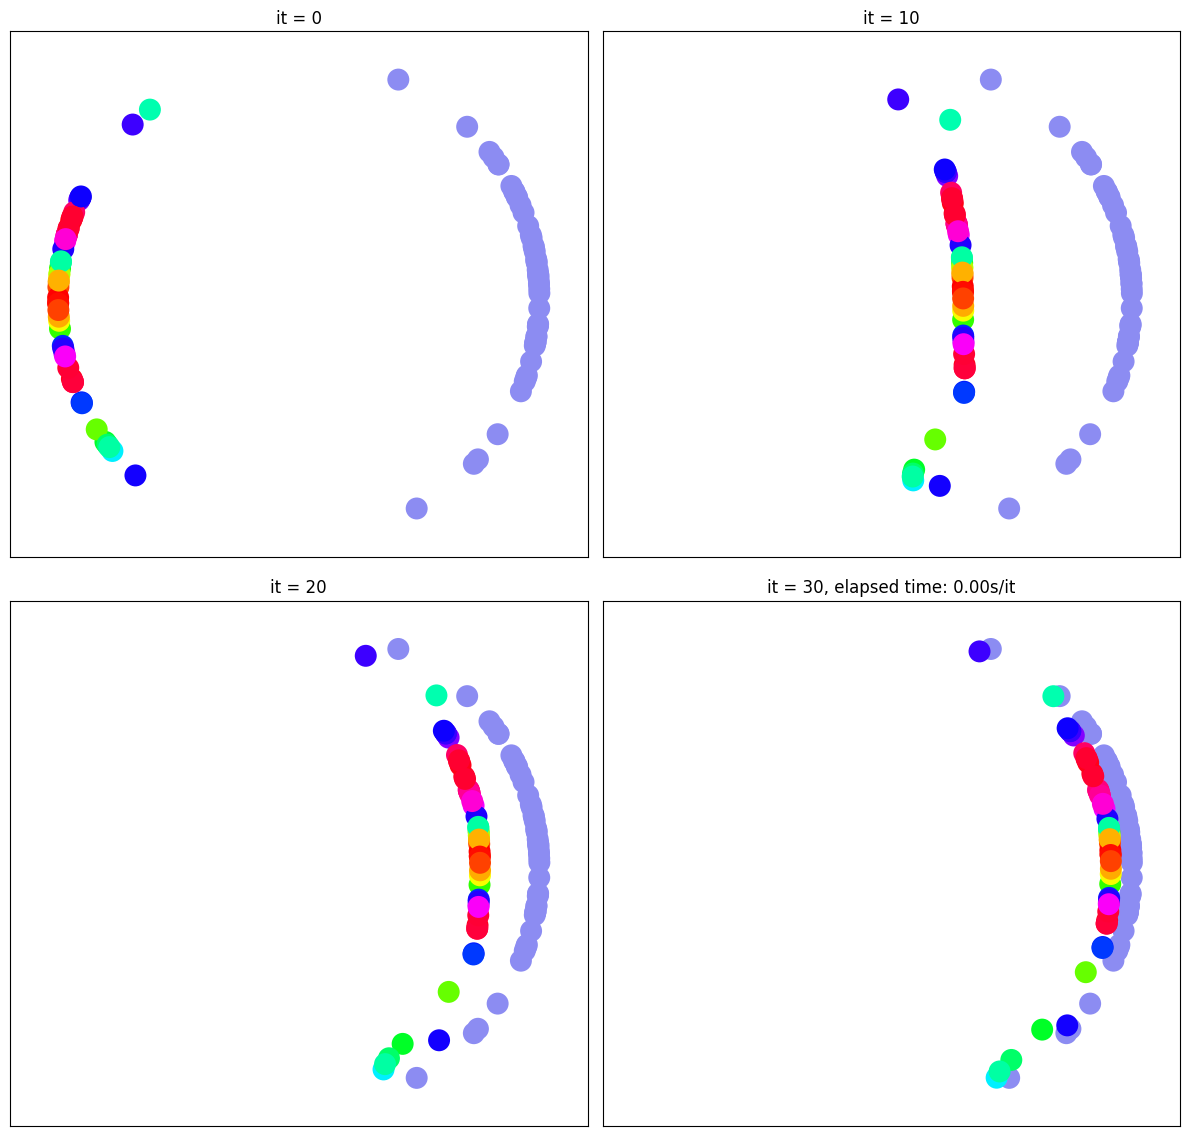

In [11]:
nb_data = 50
np.random.seed(1)
# x1 = pd.DataFrame(np.random.normal(loc=np.array([np.pi, 0]), scale=np.array([[np.pi/6, np.pi/2]]), size=(1000,2)))
# x2 = pd.DataFrame(np.random.normal(loc=np.array([0, 0]), scale=np.array([[np.pi/16, np.pi/2]]), size=(1000,2)))
x1 = pd.DataFrame(np.random.normal(loc=np.array([np.pi]), scale=np.array([np.pi/8]), size=(nb_data,1)))
x2 = pd.DataFrame(np.random.normal(loc=np.array([0]), scale=np.array([np.pi/6]), size=(nb_data,1)))

x1 = x1 % (2 * np.pi)
x2 = x2 % (2 * np.pi)

X1 = pd.concat([np.cos(x1[0]),  np.sin(x1[0])], axis=1, keys=["x", "y"])
X2 = pd.concat([np.cos(x2[0]),  np.sin(x2[0])], axis=1, keys=["x", "y"])

X_i = torch.tensor(X1.values)
Y_j = torch.tensor(X2.values)

gradient_descent2D(SamplesLoss("sinkhorn", p=2, blur=0.1),X_i, Y_j, verbose=True, lr=0.1)

all tangent computed
Launch Gradient Descent Algo on Sinkhorn
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30


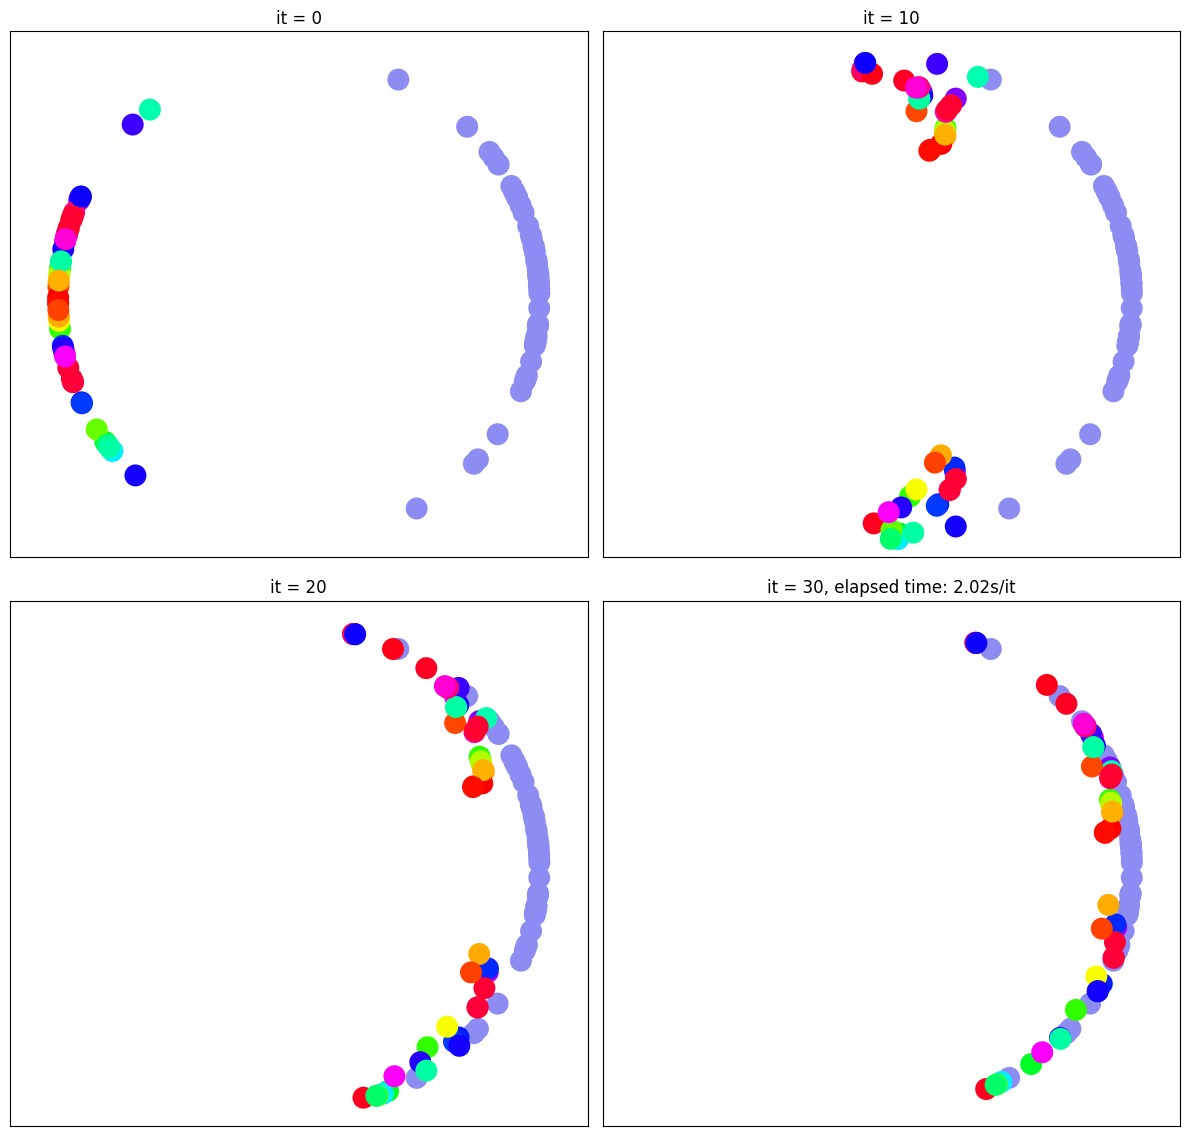

In [12]:
from ManifoldProjectLoss import ManifoldProjection, BatchingCostModule
from gen_geometry import uniform_circ
data_circ = torch.tensor(uniform_circ(200))
cost = ManifoldProjection(data_circ, k_neighbor=5, closing_manifold_ratio=0.2, manifold_ratio=0.4)
cost.precompute_all_cache()
print("all tangent computed")
cost_batched = BatchingCostModule(cost)
gradient_descent2D(SamplesLoss("sinkhorn", p=2, blur=0.1, cost=cost_batched), X_i, Y_j, verbose=True, lr=0.05)

## Horned ball plots Sinkhorn and Sinkhorn manifold aware

In [13]:
import torch
from gen_geometry import draw_horned_ball
from ManifoldProjectLoss import ManifoldProjection, BatchingCostModule
from geomloss import SamplesLoss
horn_pts, _, _ = draw_horned_ball(1000)

# Re sample to have start and end not on the mesh
_, start_pts, goal_pts = draw_horned_ball(1000)
start_pts, goal_pts = start_pts[:50], goal_pts[:50]

horn_pts, start_pts, goal_pts = torch.Tensor(horn_pts), torch.Tensor(start_pts), torch.Tensor(goal_pts)



In [14]:
print(start_pts.shape, goal_pts.shape)

torch.Size([50, 2]) torch.Size([50, 2])


Launch Gradient Descent Algo on Sinkhorn
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30


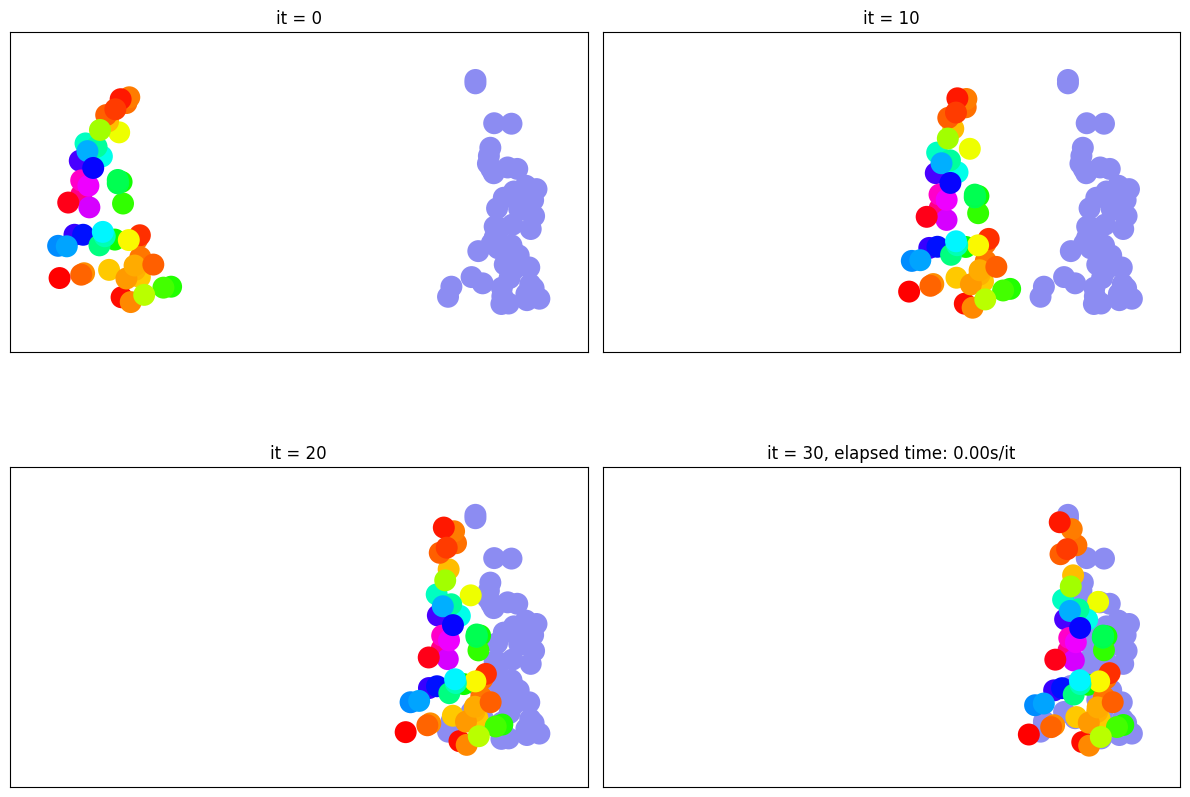

In [15]:
gradient_descent2D(SamplesLoss("sinkhorn", p=2, blur=0.1),start_pts, goal_pts, verbose=True, lr=0.1)

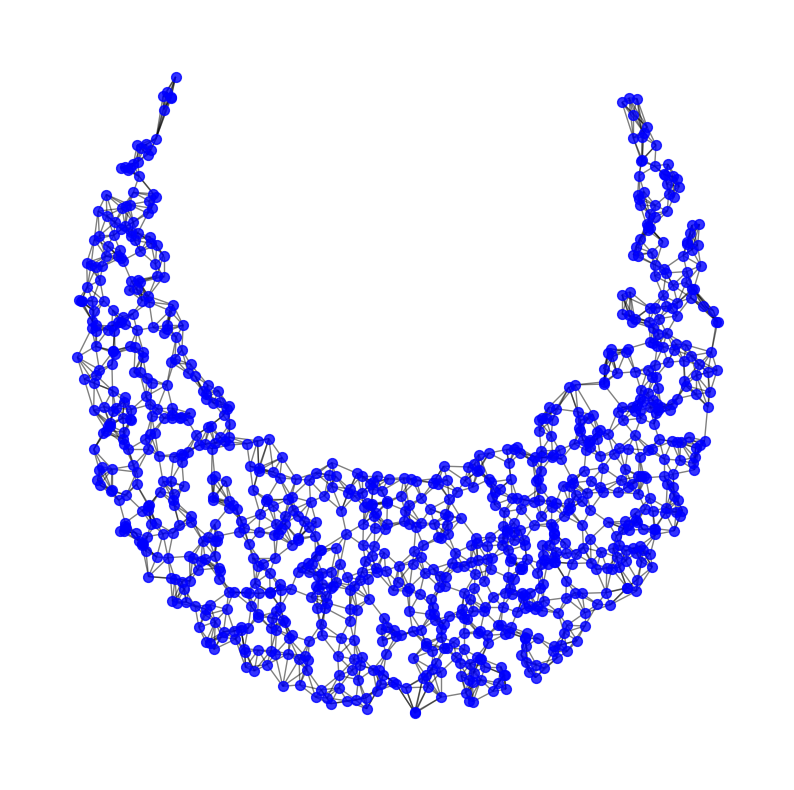

In [16]:
cost = ManifoldProjection(horn_pts, k_neighbor=7, closing_manifold_ratio=0.2, manifold_ratio=0.4)
cost.draw_graph()



In [17]:

cost.precompute_all_cache()


all tangent computed
Launch Gradient Descent Algo on Sinkhorn
step 0
step 1


ValueError: arange: cannot compute length

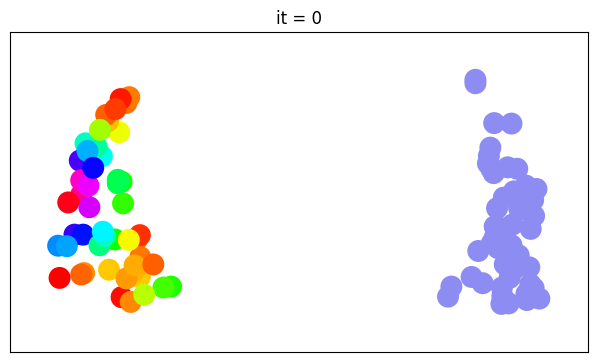

In [18]:
print("all tangent computed")
cost_batched = BatchingCostModule(cost)
gradient_descent2D(SamplesLoss("sinkhorn", p=2, blur=0.1, cost=cost_batched), start_pts, goal_pts, verbose=True, lr=0.1, display_its=[0,5,10,20])